In [1]:
import PyCO2SYS as pyco2
import pandas as pd 
import numpy as np 
import xarray as xr 
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')
import math
import gsw
import matplotlib as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


In [2]:
%run PLT.py

In [4]:
df = PLT.get_hydrocat('2022-01-01', '2022-12-30', 'PLT')
df

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total
326,2022-01-04T09:31:15.400Z,None,6.5078,31.0263,9.592,30.7871,7.478,30.272,8.04,2022-01-04 04:31:15.400000,7.934479
331,2022-01-04T10:46:15.400Z,None,6.3631,30.9445,9.663,30.8278,1.844,3.473,8.04,2022-01-04 05:46:15.400000,7.934814
332,2022-01-04T11:01:15.200Z,None,6.3063,30.8235,9.633,30.7459,2.373,15.717,8.04,2022-01-04 06:01:15.200000,7.934773
333,2022-01-04T11:16:15.200Z,None,6.2367,30.7264,9.680,30.7015,3.158,5.010,8.04,2022-01-04 06:16:15.200000,7.934821
334,2022-01-04T11:31:15.200Z,None,6.2593,30.6975,9.698,30.6492,2.170,7.818,8.03,2022-01-04 06:31:15.200000,7.924688
...,...,...,...,...,...,...,...,...,...,...,...
31734,2022-12-29T22:46:29.000Z,12/29/2022 22:45:00,3.9276,27.7203,10.546,29.3688,0.097,64.257,8.12,2022-12-29 17:46:29,8.016546
31735,2022-12-29T23:01:29.000Z,12/29/2022 23:00:00,3.9210,27.7232,10.552,29.3782,0.093,64.640,8.11,2022-12-29 18:01:29,8.006574
31736,2022-12-29T23:16:29.000Z,12/29/2022 23:15:00,3.9183,27.7297,10.567,29.3882,0.123,64.546,8.12,2022-12-29 18:16:29,8.016597
31737,2022-12-29T23:31:29.000Z,12/29/2022 23:30:00,3.9342,27.7421,10.652,29.3883,0.123,65.017,8.13,2022-12-29 18:31:29,8.026570


In [5]:
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)


Pulling Bottle samples

In [6]:
spreadsheet_key = '17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U'
wks_name = 'Sheet1'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name)

#Pulling the data and transform it to the data frame
values = sheet.get_all_values()
labdata = pd.DataFrame(values[1:], columns = values[0])
labdata.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.47,22,1985.40452,29.42,NOTE: Salinity values are currently either der...
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.78,22,1955.71939,29.42,
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22,1931.63783,29.48,
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.41,22,1931.62999,29.48,
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22,1978.53868,30,


In [7]:
df = labdata[['Sample', 'Time', 'Location', 'depth', 'TA Temp (degC)', 'TA (uM)',
       'DIC Temp (degC)', 'DIC (uM)', 'Salinity']]
df['TA (uM)'] = pd.to_numeric(df['TA (uM)'])
df['TA Temp (degC)'] = pd.to_numeric(df['TA Temp (degC)'])
df['DIC (uM)'] = pd.to_numeric(df['DIC (uM)'])
df['DIC Temp (degC)'] = pd.to_numeric(df['DIC Temp (degC)'])
df['Salinity'] = pd.to_numeric(df['Salinity'])
df["DateTime"] = pd.to_datetime(df["Time"])
df.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,29.42,2022-05-09 07:30:00
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,29.42,2022-05-09 07:30:00
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,29.48,2022-04-28 07:30:00
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,29.48,2022-04-28 07:30:00
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.00,2022-05-22 07:30:00


In [8]:
# For each index in dataframe df...
for ind in df.index:
    # if TA or DIC at that index is Nan/empty...
    if math.isnan(df['TA (uM)'][ind]) or math.isnan(df['DIC (uM)'][ind]):
        # Drop that index
        df = df.drop(ind)
        


In [9]:
labGB = df.where(df['Location']== 'GB').dropna()
labPLT = df.where(df['Location']== 'PLT').dropna()

unit conversion

In [10]:
df['P']=0 #pressure

#density
df['rho_DIC'] =gsw.rho(df['Salinity'], df['DIC Temp (degC)'], df['P'])
df['rho_TA'] = gsw.rho(df['Salinity'], df['TA Temp (degC)'], df['P']) 

# converts DIC and TA 
df['DIC (umol/kg)'] = df['DIC (uM)'] / df['rho_DIC']/.001
df['TA (umol/kg)'] = df['TA (uM)'] / df['rho_TA']/.001

df.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg)
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,29.42,2022-05-09 07:30:00,0,1019.934637,1020.378834,1946.599760,2034.019064
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,29.42,2022-05-09 07:30:00,0,1019.934637,1020.378834,1917.494827,2035.302901
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,29.48,2022-04-28 07:30:00,0,1019.979359,1020.269717,1893.800902,2037.524946
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,29.48,2022-04-28 07:30:00,0,1019.979359,1020.269717,1893.793216,2037.118191
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.00,2022-05-22 07:30:00,0,1020.366971,1020.658514,1939.046182,2095.113077


In [11]:
results = pyco2.sys(par1=df['TA (umol/kg)'],par2=df['DIC (umol/kg)'],par1_type=1,par2_type=2,salinity = df['Salinity'], temperature = df['DIC Temp (degC)'])
df['pH'] = results['pH']
df.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg),pH
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,29.42,2022-05-09 07:30:00,0,1019.934637,1020.378834,1946.599760,2034.019064,7.708114
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,29.42,2022-05-09 07:30:00,0,1019.934637,1020.378834,1917.494827,2035.302901,7.800762
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,29.48,2022-04-28 07:30:00,0,1019.979359,1020.269717,1893.800902,2037.524946,7.872124
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,29.48,2022-04-28 07:30:00,0,1019.979359,1020.269717,1893.793216,2037.118191,7.871104
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.00,2022-05-22 07:30:00,0,1020.366971,1020.658514,1939.046182,2095.113077,7.890143


In [12]:
df.dropna()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg),pH
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,29.4200,2022-05-09 07:30:00,0,1019.934637,1020.378834,1946.599760,2034.019064,7.708114
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,29.4200,2022-05-09 07:30:00,0,1019.934637,1020.378834,1917.494827,2035.302901,7.800762
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,29.4800,2022-04-28 07:30:00,0,1019.979359,1020.269717,1893.800902,2037.524946,7.872124
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,29.4800,2022-04-28 07:30:00,0,1019.979359,1020.269717,1893.793216,2037.118191,7.871104
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.0000,2022-05-22 07:30:00,0,1020.366971,1020.658514,1939.046182,2095.113077,7.890143
5,GB B 9/9/22,9/9/22 11:30,GB,surface,21.3,1957.870,22.5,1883.00000,29.0800,2022-09-09 11:30:00,0,1019.546304,1019.866601,1846.899933,1919.731461,7.665826
6,GB A 9/9/22,9/9/22 11:30,GB,surface,21.3,1955.840,22.5,1882.80000,29.0200,2022-09-09 11:30:00,0,1019.501647,1019.821797,1846.784657,1917.825258,7.660493
7,GB B 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.600,22.5,1938.60000,30.1100,2022-09-20 11:30:00,0,1020.313000,1020.635836,1900.005195,2010.119504,7.764747
8,GB A 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.930,22.5,1937.20000,30.0900,2022-09-20 11:30:00,0,1020.298111,1020.620897,1898.660774,2010.472258,7.770016
9,GB A 10/25/22,10/25/22 11:30,GB,surface,21.3,2047.245,21.1,1931.60000,29.4100,2022-10-25 11:30:00,0,1020.165379,1020.113036,1893.418498,2006.880539,7.803939


In [2]:
pH_data = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/pH.csv') 
pH_data.drop(pH_data.tail(6).index, inplace = True) 

In [3]:
pH_data["DateTime"] = pd.to_datetime(pH_data["DateTime (UTC-04:00)"]) - timedelta(hours = 5) 

In [7]:
type(pH_data["DateTime"])

pandas.core.series.Series

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

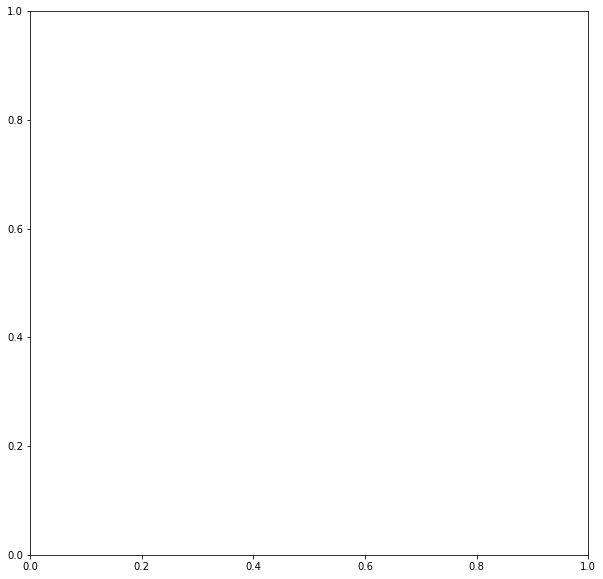

In [16]:
fig,ax = plt.subplots(figsize=[10,10])
ax.plot(pH_data['DateTime'], pH_data['External pH (pH)'], color = 'pink', label = 'SeaFET')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

Pulling Andy Davis data using PLT.py

Text(0.5, 0, 'Year-Month')

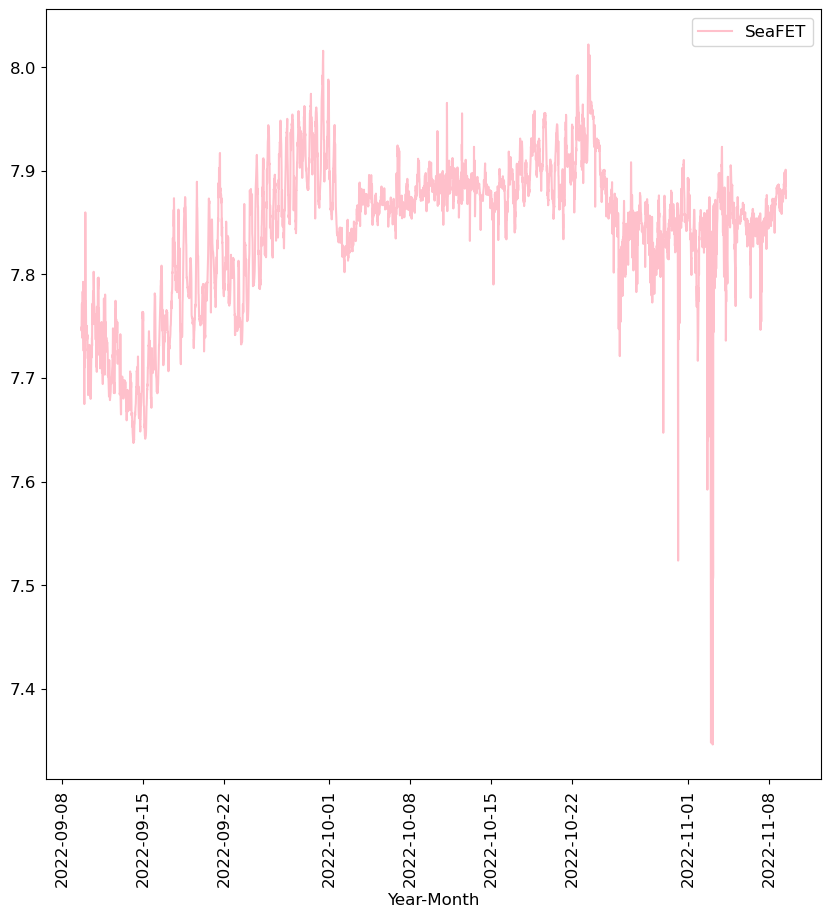

In [6]:
fig,ax = plt.subplots(figsize=[10,10])
ax.plot(pH_data['DateTime'], pH_data['External pH (pH)'], color = 'pink', label = 'SeaFET')
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

In [101]:
# AD = PLT.get_hydrocat('2023-01-01', '2023-05-01', 'PLT') 



In [102]:
# AndyPLT = AD[['TmStamp', 'hydrocatStart', 'hydrocatTemperature', 'hydrocatConductivity', 'hydrocatDissOxygen', 'hydrocatSalinity', 'hydrocatFluorescence','hydrocatTurbidity','hydrocatPH','DateTime','pH total']]
# AndyPLT['Temp (C)'] = pd.to_numeric(AndyPLT['hydrocatTemperature'])
# AndyPLT['DissOxygen'] = pd.to_numeric(AndyPLT['hydrocatDissOxygen'])
# AndyPLT['Time'] = pd.to_datetime(AndyPLT['DateTime'])
# AndyPLT['pH'] = pd.to_numeric(AndyPLT['pH total'])
# AndyPLT.head()

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total,Temp (C),DissOxygen,Time,pH
0,2023-01-01T00:01:48.200Z,01/01/2023 00:00:18,4.5822,27.3644,10.726,28.3834,0.103,64.408,8.18,2022-12-31 19:01:48.200000,8.073679,4.5822,10.726,2022-12-31 19:01:48.200,8.073679
1,2023-01-01T00:16:32.800Z,01/01/2023 00:15:00,4.5847,27.4003,10.526,28.4223,0.110,63.774,8.17,2022-12-31 19:16:32.800000,8.063742,4.5847,10.526,2022-12-31 19:16:32.800,8.063742
2,2023-01-01T00:31:30.800Z,01/01/2023 00:30:00,4.5905,27.4014,10.619,28.4186,0.097,63.988,8.17,2022-12-31 19:31:30.800000,8.063726,4.5905,10.619,2022-12-31 19:31:30.800,8.063726
3,2023-01-01T00:46:30.800Z,01/01/2023 00:45:00,4.5685,27.4159,10.547,28.4540,0.099,64.130,8.18,2022-12-31 19:46:30.800000,8.073825,4.5685,10.547,2022-12-31 19:46:30.800,8.073825
4,2023-01-01T01:01:30.800Z,01/01/2023 01:00:00,4.5043,27.3451,10.763,28.4283,0.104,64.697,8.18,2022-12-31 20:01:30.800000,8.073890,4.5043,10.763,2022-12-31 20:01:30.800,8.073890


Graph comparing Dissolved Oxygen and pH using Andy Davis' PLT Data

Text(0, 0.5, 'pH')

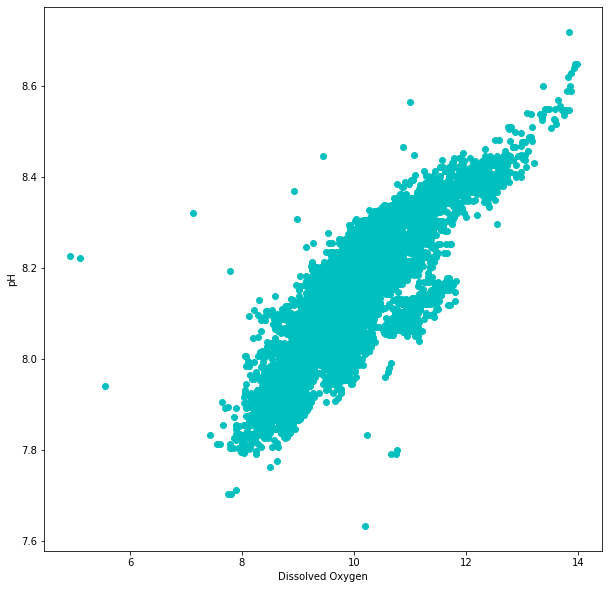

In [103]:
# fig,ax = plt.subplots (figsize = [10,10]) 
# ax.scatter(Andy['DissOxygen'],Andy['pH'], color = 'c')
# ax.set_xlabel("Dissolved Oxygen")
# ax.set_ylabel("pH")

plot date and ph 


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

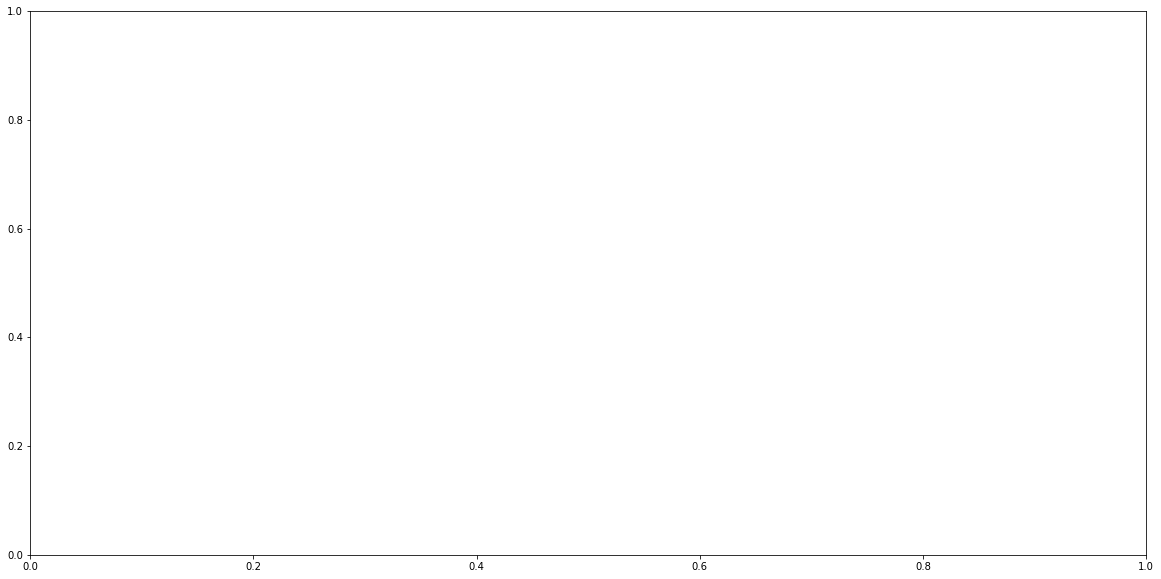

In [108]:
# fig,ax = plt.subplots(figsize=[20,10])
# ax.plot(AndyPLT['DateTime'], AndyPLT['pH total'], color = 'pink', label = 'Hydrocat PLT 620')
# ax.plot(andyGB['DateTime'], andyGB['pH total'], color = 'purple', label = 'Hydrocat GB 720')
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.tick_params('x',labelsize = 12, labelrotation = 90)
# ax.tick_params('y',labelsize = 12)
# ax.legend(fontsize = 12)
# ax.set_ylim([7,9])
# ax.set_xlabel('Year-Month', fontsize = 12)